In [1]:
import pandas as pd
import time
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

## 데이터 불러오기 및 확인

In [2]:
use_data = pd.read_csv('test_data.csv', parse_dates=['_time'], index_col='_time')
# use_data['_value']=use_data['_value']+300
use_data

,_value
_time,
2024-09-29 00:00:00+09:00,349.483236
2024-09-29 00:01:00+09:00,349.522426
2024-09-29 00:02:00+09:00,349.532876
2024-09-29 00:03:00+09:00,349.538101
2024-09-29 00:04:00+09:00,349.668733
...,...
2024-09-29 23:55:00+09:00,348.284038
2024-09-29 23:56:00+09:00,348.216110
2024-09-29 23:57:00+09:00,348.226560


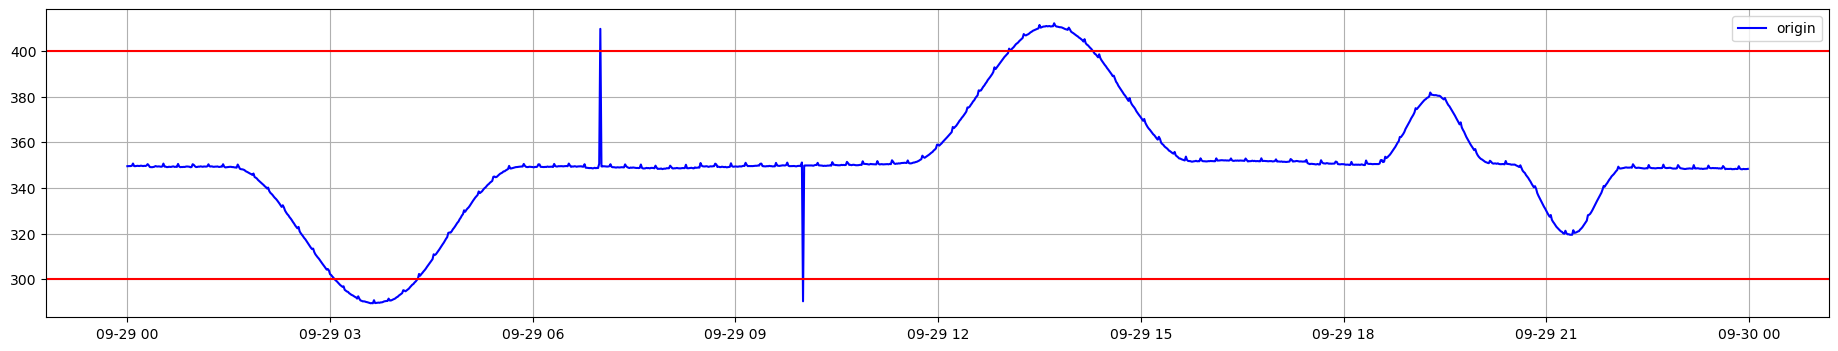

In [3]:
plt.figure(figsize=(23,4))
plt.plot(use_data.index, use_data, label='origin', color='blue')
plt.legend()
plt.grid()
plt.axhline(300,color='red')
plt.axhline(400,color='red')
plt.show()

## 예측하기

In [4]:
results = []
test_count = 0
time_start = time.time()

# 슬라이딩 예측 수행 (전체 데이터에서 1분 간격으로 학습 시작 시간 설정)
start_time = use_data.index.min()

# end_time을 데이터의 마지막 시간 1분 전으로 설정
end_time = use_data.index[-1] - pd.Timedelta(minutes=1)

# start_time부터 end_time까지 1분씩 증가하면서 슬라이딩
while start_time + pd.Timedelta(hours=1) <= end_time:
    train_end = start_time + pd.Timedelta(hours=1)  # 학습 시간 구간 설정 (1시간)
    
    # 1시간 간격 데이터 추출
    train_window = use_data.loc[start_time:train_end]  
    
    # 데이터 개수가 60개 이상일 때만 ARIMA 모델 학습
    if len(train_window) > 60:
        # ARIMA 모델 학습
        model = ARIMA(train_window, order=(12, 2, 6))
        model_fit = model.fit()

        # 30분 예측
        forecast = model_fit.forecast(steps=30)
        forecast_df = pd.DataFrame(forecast)
        forecast_transpose = forecast_df.T
        forecast_transpose.index = [forecast_transpose.columns[0]]
        forecast_transpose.columns = [f'{i}min_later' for i in range(1, len(forecast_transpose.columns) + 1)]
        forecast_transpose['pred_max'] = forecast_transpose.iloc[0].max()
        forecast_transpose['alarm'] = (forecast_transpose.iloc[0] > 65).any()
        results.append(forecast_transpose)
        test_count+=1
        print(f'{test_count}번째 테스트 완료')

    # 1분 간격으로 학습 시작 시간 이동
    start_time += pd.Timedelta(minutes=1)

# 결과를 하나의 데이터프레임으로 합치기
results_df = pd.concat(results)

# final_alarm 열 생성 및 alarm 기준 설정
results_df['final_alarm'] = False

# 연속 5번 alarm이 True인 경우 final_alarm을 True로 설정
results_df['consecutive_alarm'] = results_df['alarm'].rolling(window=5).apply(lambda x: all(x), raw=True)

# consecutive_alarm이 1 이상인 행에 대해 final_alarm을 True로 설정
results_df['final_alarm'] = results_df['consecutive_alarm'] >= 1

# 연속 여부를 확인하는 임시 열 제거
results_df.drop(columns='consecutive_alarm', inplace=True)

## 결과물 생성 및 병합 부분은 동일
use_data_A = use_data.copy()

#실제 값에서부터 30분 미래까지의 최대값 확인
use_data_A['real_max'] = use_data_A['_value'][::-1].rolling(window=30, min_periods=1).max()[::-1]
use_data_A.fillna(0, inplace=True)

#30분 미래값에서 65를 넘는값이 있다면 비정상으로 확인
use_data_A['abnormal'] = (use_data_A['real_max'] > 65)
use_data_A['abnormal'].fillna(False, inplace=True)

# final_abnormal 열 생성 및 abnormal 기준 설정
use_data_A['final_abnormal'] = False
use_data_A['consecutive_abnormal'] = use_data_A['abnormal'].rolling(window=5).apply(lambda x: all(x), raw=True)
use_data_A['final_abnormal'] = use_data_A['consecutive_abnormal'] >= 1
use_data_A.drop(columns='consecutive_abnormal', inplace=True)

# #30분 미래값, 실제 비정상여부, 알람여부 확인
merged_df = results_df.merge(use_data_A[['real_max', 'abnormal', 'final_abnormal']], left_index=True, right_index=True, how='left')
merged_df['result'] = merged_df['final_abnormal'] == merged_df['final_alarm']
merged_df.to_csv('result/total_test.csv')

1번째 테스트 완료
2번째 테스트 완료
3번째 테스트 완료
4번째 테스트 완료
5번째 테스트 완료
6번째 테스트 완료
7번째 테스트 완료
8번째 테스트 완료
9번째 테스트 완료
10번째 테스트 완료
11번째 테스트 완료
12번째 테스트 완료
13번째 테스트 완료
14번째 테스트 완료
15번째 테스트 완료
16번째 테스트 완료
17번째 테스트 완료
18번째 테스트 완료
19번째 테스트 완료
20번째 테스트 완료
21번째 테스트 완료
22번째 테스트 완료
23번째 테스트 완료
24번째 테스트 완료
25번째 테스트 완료
26번째 테스트 완료
27번째 테스트 완료
28번째 테스트 완료
29번째 테스트 완료
30번째 테스트 완료
31번째 테스트 완료
32번째 테스트 완료
33번째 테스트 완료
34번째 테스트 완료
35번째 테스트 완료
36번째 테스트 완료
37번째 테스트 완료
38번째 테스트 완료
39번째 테스트 완료
40번째 테스트 완료
41번째 테스트 완료
42번째 테스트 완료
43번째 테스트 완료
44번째 테스트 완료
45번째 테스트 완료
46번째 테스트 완료
47번째 테스트 완료
48번째 테스트 완료
49번째 테스트 완료
50번째 테스트 완료
51번째 테스트 완료
52번째 테스트 완료
53번째 테스트 완료
54번째 테스트 완료
55번째 테스트 완료
56번째 테스트 완료
57번째 테스트 완료
58번째 테스트 완료
59번째 테스트 완료
60번째 테스트 완료
61번째 테스트 완료
62번째 테스트 완료
63번째 테스트 완료
64번째 테스트 완료
65번째 테스트 완료
66번째 테스트 완료
67번째 테스트 완료
68번째 테스트 완료
69번째 테스트 완료
70번째 테스트 완료
71번째 테스트 완료
72번째 테스트 완료
73번째 테스트 완료
74번째 테스트 완료
75번째 테스트 완료
76번째 테스트 완료
77번째 테스트 완료
78번째 테스트 완료
79번째 테스트 완료
80번째 테스트 완료
81번째 테스트 완료
82번째 테스트 완료
83번째 테스트 완료
84번째 테스트 완료
8

## 예측trend확인하기

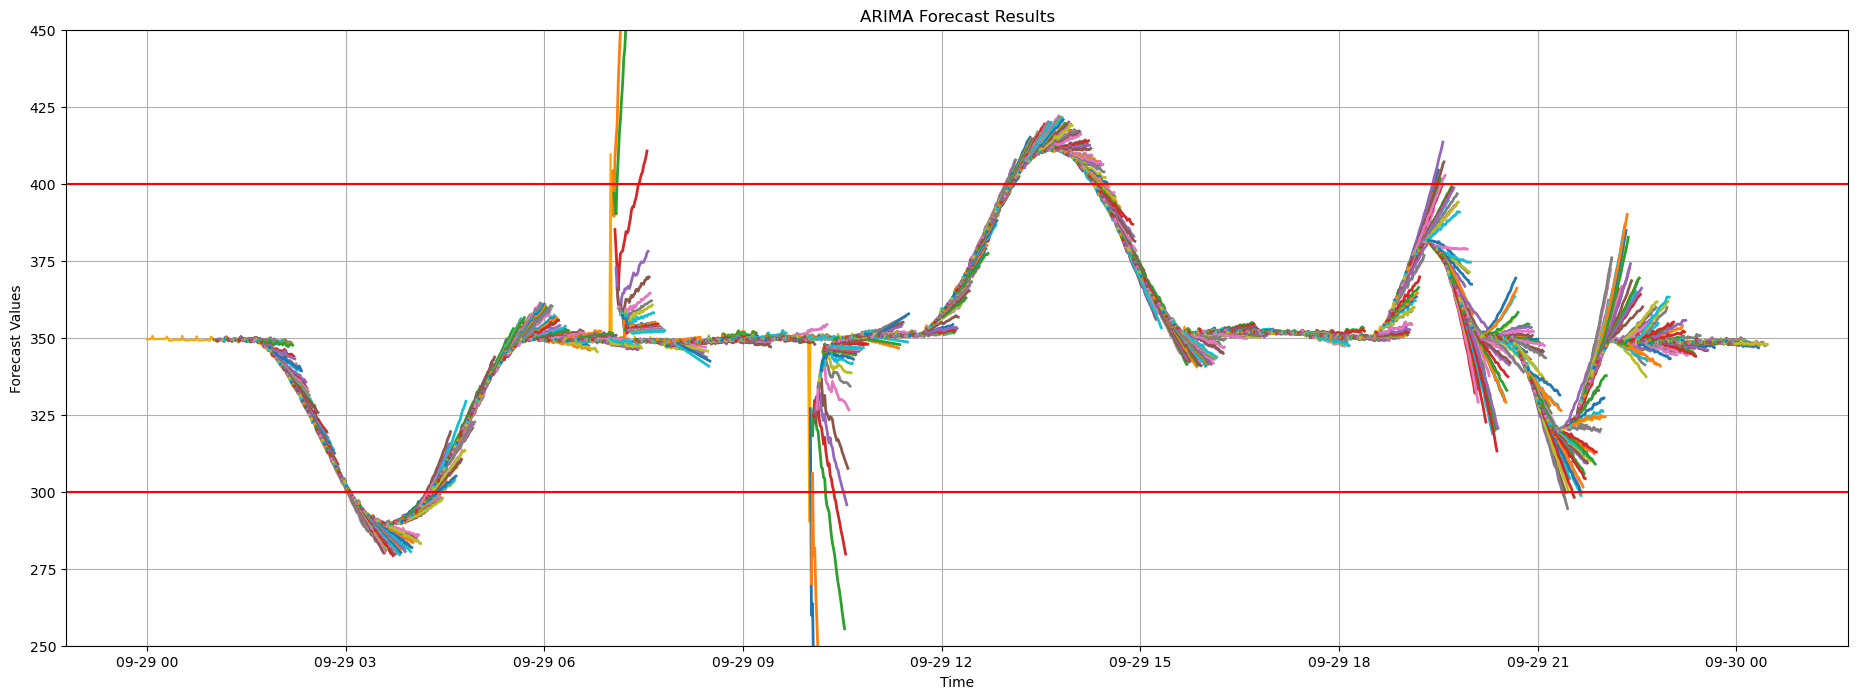

In [5]:
# 그래프 그리기
plt.figure(figsize=(23, 8))
plt.plot(use_data.index, use_data['_value'], label='use_data (original data)', color='orange')

# 예측 결과 플로팅
for i, result in enumerate(results):
    forecast_start_time = result.index[0]  # 예측 시작 시간
    forecast_values = result.iloc[0, :-2]  # 예측된 값 (마지막 열은 'alarm'임)
    forecast_index = pd.date_range(start=forecast_start_time, periods=len(forecast_values), freq='T')
    plt.plot(forecast_index, forecast_values, label=f'Forecast {i + 1}', linestyle='-', linewidth=2)

# 플롯 라벨과 제목 설정
plt.xlabel('Time')
plt.ylabel('Forecast Values')
plt.title('ARIMA Forecast Results')
plt.grid()
plt.ylim(250,450)
plt.axhline(300,color='red')
plt.axhline(400,color='red')
plt.show()